# Importing Libraries

In [2]:
# For handling data
import pandas as pd
# For numerical operations
import numpy as np

# Used to load a machine learning model
import pickle

# For basic plotting and visualizations
import matplotlib.pyplot as plt
# For advanced and beautiful statistical plots
import seaborn as sns

# To find files/pathnames matching a pattern
import glob
# To interact with the operating system (like file paths)
import os

# To split dataset into train & test sets
from sklearn.model_selection import train_test_split
# Random Forest model for classification
from sklearn.ensemble import RandomForestClassifier
# To evaluate model performance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# Configure the style of seaborn plots
sns.set_style('whitegrid')
# Enable inline plotting so that plots appear directly in the notebook
%matplotlib inline

# Load Dataset Files

In [4]:
def load_data(folder_path='data'):
    
    # Find all .pkl files in the directory
    file_list = glob.glob(os.path.join(folder_path, "*.pkl"))
    
    if not file_list:
        # Fallback: try loading from current directory if 'data' folder is empty/missing
        file_list = glob.glob("*.pkl")
        if not file_list:
            raise FileNotFoundError("No .pkl files found in 'data' folder or current directory.")
    
    print(f"Found {len(file_list)} dataset files. Loading...")
    
    # Load and concatenate
    df_list = [pd.read_pickle(file) for file in file_list]
    df = pd.concat(df_list, ignore_index=True)
    
    print(f"Data Loaded sucessfully. Shape: {df.shape}")
    return df

# Load the dataset and display first few rows
try:
    df = load_data()
    # Display first few rows to verify
    display(df.head())
except Exception as e:
    print(f"Error: {e}")

Found 183 dataset files. Loading...
Data Loaded sucessfully. Shape: (1754155, 9)


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


# Feature Engineering

In [6]:
# Clean the dataset and create meaningful features for the ML model.
def preprocess_and_feature_engineering(input_df):

    # Make a copy to avoid modifying the original DataFrame
    df_clean = input_df.copy()
    
    # 1. Convert transaction timestamp to datetime object for easier feature extraction
    df_clean['TX_DATETIME'] = pd.to_datetime(df_clean['TX_DATETIME'])
    
    # 2. Feature Engineering: Time-based features
    # Fraud often happens at specific hours (e.g., late night)
    df_clean['TX_HOUR'] = df_clean['TX_DATETIME'].dt.hour
    
    # Extract day of the week (0=Monday, 6=Sunday)
    df_clean['TX_DAY_OF_WEEK'] = df_clean['TX_DATETIME'].dt.dayofweek
    
    # 3. Feature Selection: Choose important columns only
    # Avoid using IDs as features because they can lead to overfitting
    features = ['TX_AMOUNT', 'TX_HOUR', 'TX_DAY_OF_WEEK', 'TX_TIME_DAYS']
    target = 'TX_FRAUD'
    
    # Separate X (Inputs) and y (Output)
    X = df_clean[features]
    y = df_clean[target]
    
    print(f"Selected Features: {features}")
    return X, y

# Execute preprocessing and feature engineering
X, y = preprocess_and_feature_engineering(df)

# Check Class Balance
print("\nTarget Distribution (0 = Legit, 1 = Fraud):")
print(y.value_counts(normalize=True))

Selected Features: ['TX_AMOUNT', 'TX_HOUR', 'TX_DAY_OF_WEEK', 'TX_TIME_DAYS']

Target Distribution (0 = Legit, 1 = Fraud):
TX_FRAUD
0    0.991631
1    0.008369
Name: proportion, dtype: float64


# Split Dataset into Training and Testing Sets

In [8]:
# Stratify=y ensures the proportion of fraud is the same in training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Data split successfully.")
print(f"Training Set: {X_train.shape}")
print(f"Testing Set:  {X_test.shape}")

Data split successfully.
Training Set: (1403324, 4)
Testing Set:  (350831, 4)


# Train Random Forest Classifier algorithm

In [10]:
print("Initializing Random Forest Classifier...")

# Initialize model
# n_estimators=100: Builds 100 decision trees
# class_weight='balanced_subsample': Penalizes mistakes on fraud cases more heavily
# n_jobs=-1: Uses all processor cores to speed up training
rf_model = RandomForestClassifier(
    n_estimators=100, 
    class_weight='balanced_subsample', 
    random_state=42, 
    n_jobs=-1
)

print("Training started...")
# Train the model on the training data
rf_model.fit(X_train, y_train)
print("Model Training Completed.")

Initializing Random Forest Classifier...
Training started...
Model Training Completed.


# Make Predictions and Check Accuracy

In [12]:
# Make predictions on the test set
# Predicted class labels (0 = Legit, 1 = Fraud)
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1] # Predicted probability of fraud

# Training accuracy: how well the model fits training data
train_acc = rf_model.score(X_train, y_train)
# Testing accuracy: how well the model generalizes to unseen data
test_acc = accuracy_score(y_test, y_pred)

# Print results
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:     {test_acc:.4f}")

Training Accuracy: 0.9998
Test Accuracy:     0.9929


# Classification Report

In [14]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    347895
           1       0.77      0.22      0.35      2936

    accuracy                           0.99    350831
   macro avg       0.88      0.61      0.67    350831
weighted avg       0.99      0.99      0.99    350831



# Feature Importance

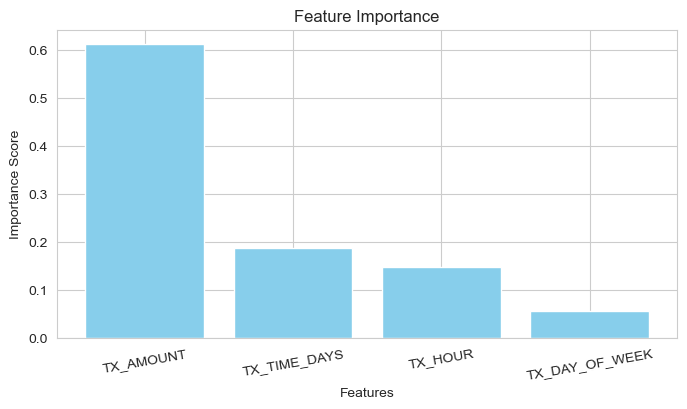

In [16]:
# Get feature importances from the trained Random Forest model
importances = rf_model.feature_importances_

# Sort features by importance (descending order)
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Plot feature importance
plt.figure(figsize=(8, 4))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align="center", color='skyblue')
plt.xticks(range(X.shape[1]), feature_names[indices])
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=10)
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.show()

# Predict using new datas

In [18]:
def predict_fraud_manual(trained_model):
    print("\n=== Enter Transaction Details ===")

    # Enter values here
    TX_AMOUNT = 2000          # Amount of the transaction
    TX_HOUR = 2               # Hour of transaction (0–23)
    TX_DAY_OF_WEEK = 2        # Day of week (0=Mon, 6=Sun)
    TX_TIME_DAYS = 3          # Time since first transaction

    # Create a DataFrame for model input
    input_df = pd.DataFrame([{
        'TX_AMOUNT': TX_AMOUNT,
        'TX_HOUR': TX_HOUR,
        'TX_DAY_OF_WEEK': TX_DAY_OF_WEEK,
        'TX_TIME_DAYS': TX_TIME_DAYS
    }])

    # Make prediction and get probabilities
    prediction = trained_model.predict(input_df)[0]
    proba = trained_model.predict_proba(input_df)[0]

    if prediction == 1:
        status = "FRAUD DETECTED"
        probability = proba[1]
        color = "\033[91m"
    else:
        status = "Legitimate Transaction"
        probability = proba[0]
        color = "\033[92m"

    reset = "\033[0m"

    # Display transaction details and prediction
    print("\n=== Prediction Result ===")
    print(f"TX_AMOUNT: {TX_AMOUNT}")
    print(f"TX_HOUR: {TX_HOUR}")
    print(f"TX_DAY_OF_WEEK: {TX_DAY_OF_WEEK}")
    print(f"TX_TIME_DAYS: {TX_TIME_DAYS}")

    print(f"{color}Prediction: {status}{reset}")
    print(f"Probability: {probability:.2%}")
    print("---------------------------------------")

    return prediction

predict_fraud_manual(rf_model)


=== Enter Transaction Details ===

=== Prediction Result ===
TX_AMOUNT: 2000
TX_HOUR: 2
TX_DAY_OF_WEEK: 2
TX_TIME_DAYS: 3
Prediction: FRAUD DETECTED
Probability: 86.00%
---------------------------------------


1

# Save the model

In [20]:
# Save the model to a file
with open("model.pkl", "wb") as f:
    pickle.dump(rf_model, f)